---
date: 12-09-2024
author: Martin Proks
title: scANVI Explainer demo
---

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [20]:
import shap
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData
from scvi.hub import HubModel
from scanvi_explainer import SCANVIDeep
from sklearn.model_selection import train_test_split

import warnings

from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)


def train_test_group_split(adata: AnnData, groupby: str):
    """
    Function to split anndata object 80/20 per group in format
    required for SCANVIDeep explainer.
    """
    groups = adata.obs.groupby(groupby)
    train, test = [], []
    for _, cells in groups.groups.items():
        train_test = train_test_split(cells.values, test_size=0.2)
        
        train.append(train_test[0])
        test.append(train_test[1])

    train, test = np.concatenate(train), np.concatenate(test)

    X_train = {
        'X': torch.from_numpy(adata[train].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[train].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[train].obs.ct.cat.codes.values[:, np.newaxis])
    }

    X_test = {
        'X': torch.from_numpy(adata[test].layers['counts'].A).type(torch.DoubleTensor),
        'batch': torch.from_numpy(adata[test].obs.batch.cat.codes.values[:, np.newaxis]),
        'labels': torch.from_numpy(adata[test].obs.ct.cat.codes.values[:, np.newaxis])
    }
    
    return X_train, X_test


def feature_plot(X_test, shap_values: np.ndarray, classes: pd.Index, features: np.ndarray, subset: bool = False):
    """
    Prints feature contribution (absolute mean SHAP value) for each cell type (top 10).

    X_test: 
        test dataset
    shap_values: 
        SHAP values
    classes: 
        list of classifiers (cell types in this case)
    features: 
        list of genes (HVGs)
    subset: 
        If True calculate contribution by subsetting for test cells which belong to that particual classifier
        Else Be generic and return contributing features even when testing set has different cell types
    """
    fig, ax = plt.subplots(8, 2, sharex=False, figsize=[20, 40])
    
    for idx, ct in enumerate(classes):
    
        shaps = pd.DataFrame(shap_values[idx], columns=features)

        if subset:
            shaps['ct'] = X_test['labels']
            shaps = shaps.query('ct == @idx').iloc[:, :-1]

            tmp_avg = shaps\
                .mean(axis=0)\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'index':'feature',0:'weight'})\
            
            positive = tmp_avg.query('weight > 0').head(5)
            negative = tmp_avg.query('weight < 0').tail(5)

            avg = pd.concat([positive, negative])
            title = f'Mean(SHAP value average importance for: {ct}'
            
        else:
            avg = shaps\
                .abs()\
                .mean(axis=0)\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'index':'feature',0:'weight'})\
                .query('weight > 0')\
                .head(10)
            title = f'Mean(|SHAP value|) average importance for: {ct}'
    
        sns.barplot(x='weight', y='feature', data=avg, ax=ax[idx // 2, idx % 2])
        ax[idx // 2, idx % 2].set_title(title)

In [5]:
hmo = HubModel.pull_from_huggingface_hub(
    repo_name="brickmanlab/mouse-scanvi",
    cache_dir="/tmp/mouse_scanvi",
    revision="v1.0",
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/271M [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/8.35M [00:00<?, ?B/s]

In [6]:
lvae = hmo.model
lvae

INFO     Loading model...                                                                                          
INFO     File                                                                                                      
         /tmp/mouse_scanvi/models--brickmanlab--mouse-scanvi/snapshots/122feddff5447c62e8a0b320650dbb6c7a1d764a/mod
         el.pt already downloaded                                                                                  


The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/projects/data/Brickman/conda/envs/scvi- ...


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [7]:
background, test = train_test_group_split(lvae.adata, groupby='ct')

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)


In [8]:
e = SCANVIDeep(lvae.module, background)

In [9]:
shap_values = e.shap_values(test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [18:36<00:00, 74.41s/it]


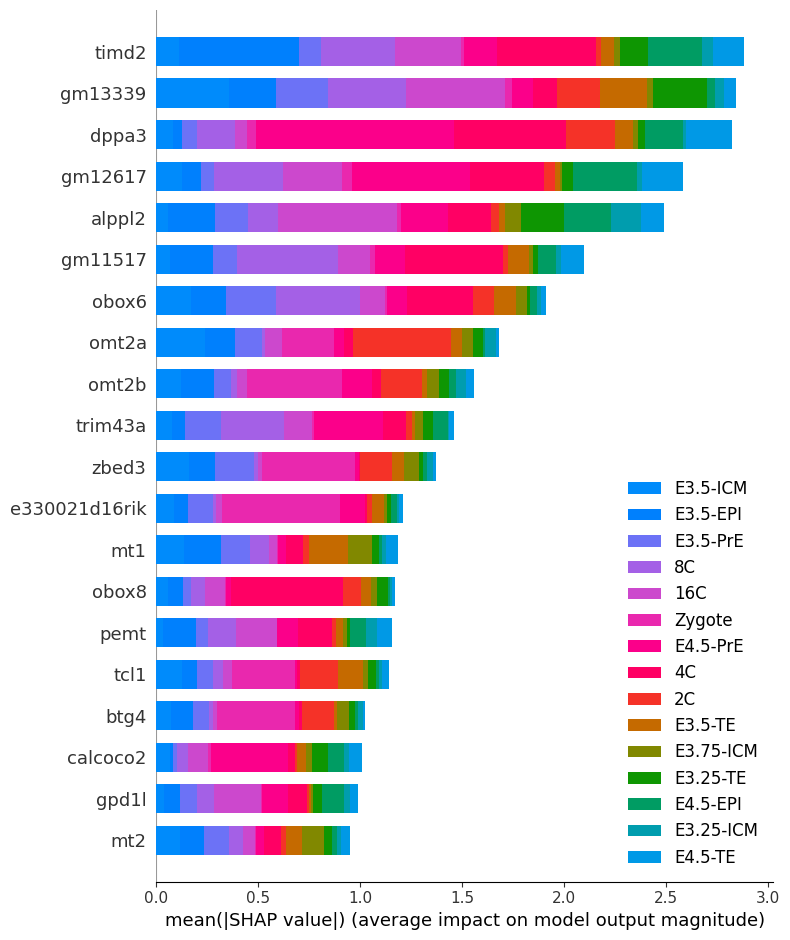

In [12]:
shap.summary_plot(
    shap_values, 
    test['X'], 
    feature_names=lvae.adata.var_names, 
    class_names=lvae.adata.obs.ct.cat.categories
)

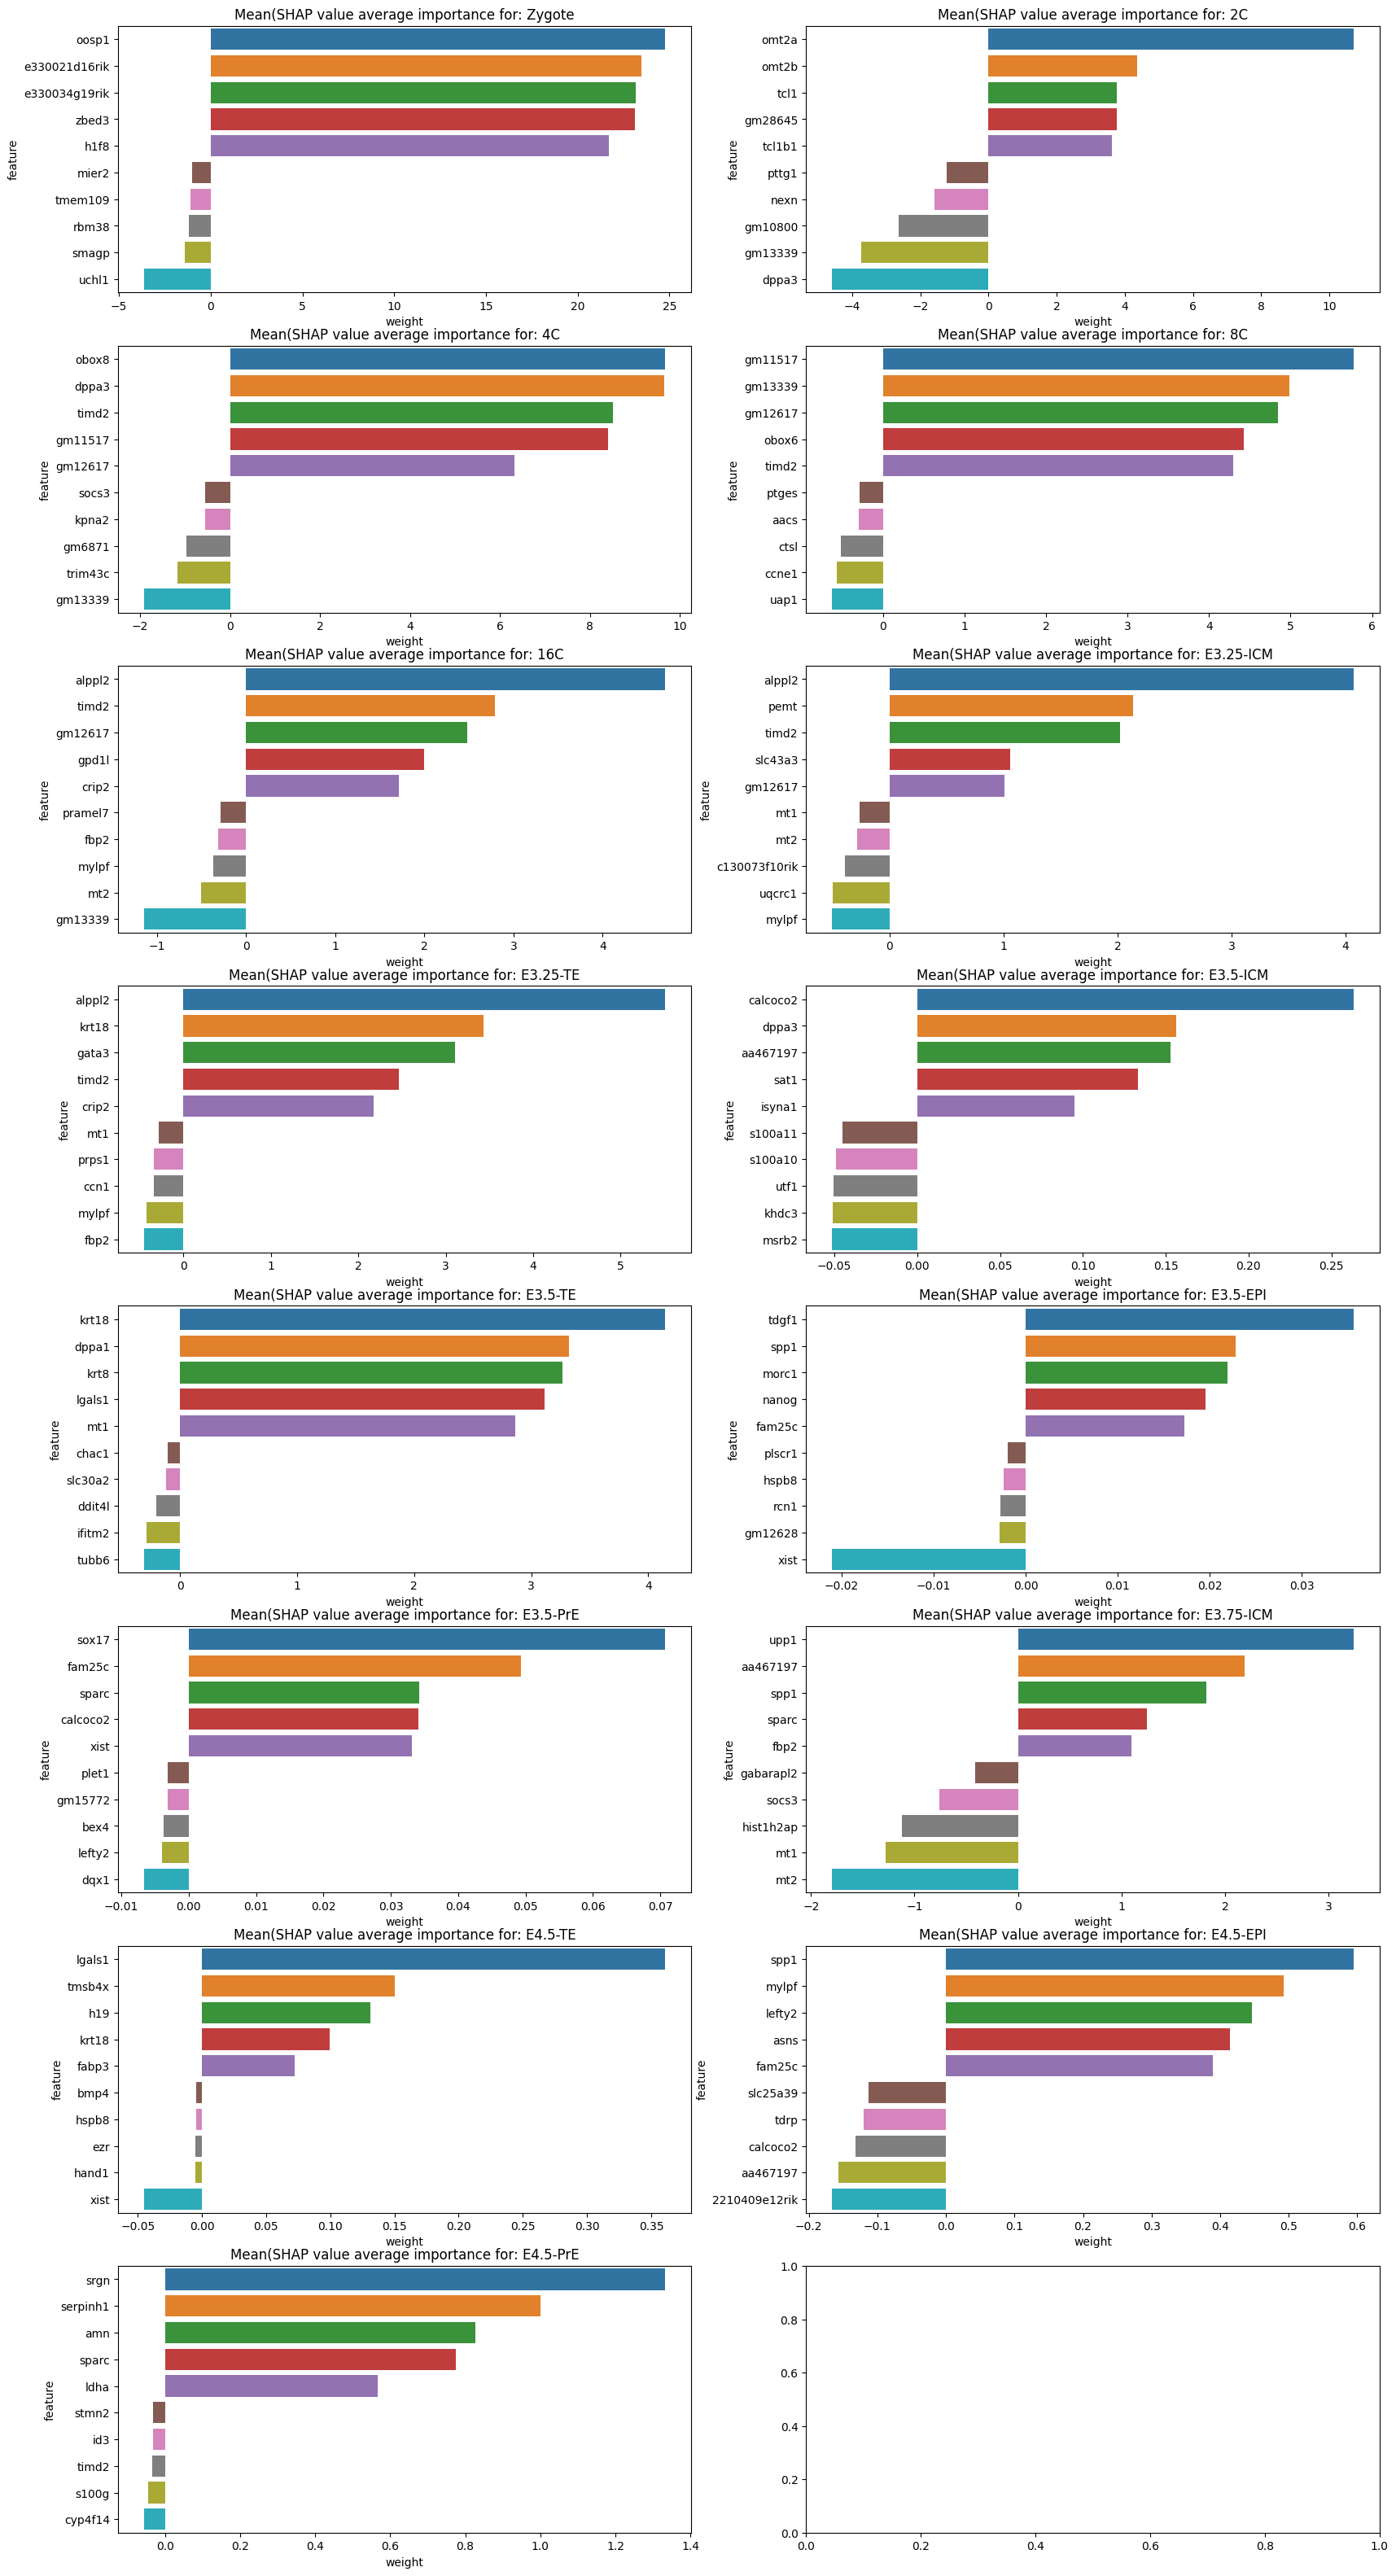

In [21]:
feature_plot(test, shap_values, classes=lvae.adata.obs.ct.cat.categories, features=lvae.adata.var_names, subset=True)